# VIKING/ HSC WIDE run

In this directory we are performing an all band selected processing of VIKING J,H,Ks and HSC G,R,I,Z,Y PDR2 WIDE data.

This was originally only producing files for the XMM W02 field but now produces dictionaries for all fields.

In this notebook we plot the VIKING tiles, over the tracts to patches to check coverages and then create the slurm jobs required to send the jobs to IRIS as arrays. We will also calculate times based on benchmarking on the SXDS field.

We will try to make a job dictionary for each field independently.

In [1]:
from astropy.table import Table,Column
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import json

#We are using a rings skymap
from lsst.geom import SpherePoint 
from lsst.geom import degrees
from lsst.skymap.ringsSkyMap import RingsSkyMap, RingsSkyMapConfig

config = RingsSkyMapConfig()
#These config options are chose to be the same as HSC:
#https://github.com/lsst/obs_subaru/blob/master/config/hsc/makeSkyMap.py
config.numRings = 120
config.projection = "TAN"
config.tractOverlap = 1.0/60 
config.pixelScale = 0.168
sm = RingsSkyMap(config)

In [2]:
viking_ims = Table.read('../../dmu1/data/viking_images_overview_20201218.csv')
hsc_ims = Table.read('../../dmu1/data/hsc_images_overview_20210315.csv')

In [3]:
viking_total_patch_dict = json.loads(open('../../dmu1/json/viking_total_patch_dict.json', 'r').read())

In [4]:
hsc_bands = ['G', 'R', 'I', 'Z', 'Y']
vista_bands = ['Y', 'J', 'H', 'Ks']
patch_files = {
    'w01':'../../dmu0/dmu0_HSC/tracts_patches/tracts_patches_W-w01.txt',
    'w02':'../../dmu0/dmu0_HSC/tracts_patches/tracts_patches_W-w02.txt',
    'w03':'../../dmu0/dmu0_HSC/tracts_patches/tracts_patches_W-w03.txt',
    'w04':'../../dmu0/dmu0_HSC/tracts_patches/tracts_patches_W-w04.txt',
    'w05':'../../dmu0/dmu0_HSC/tracts_patches/tracts_patches_W-w05.txt',
}

## 1. Plot the regions and compute tile/patch numbers

In [5]:
viking_ims.add_column(Column(
    data= [t.split('/')[-2] for t in viking_ims['file']],
    name='date'))

In [6]:
def fileToNumObs(filename):
    "Parse the file name to an obsNum"
    numObs = filename.split('_')[1].strip('_st_tl_conf.fit')
    return numObs
viking_ims['numObs'] = [fileToNumObs(f) for f in viking_ims['file']]

In [7]:
hsc_ims['tract'] = [f.split('/')[16] for f in hsc_ims['file']]
hsc_ims['patch'] = [f.split('/')[17] for f in hsc_ims['file']]
hsc_ims['depth'] = [f.split('/')[13] for f in hsc_ims['file']]
hsc_ims['band'] = [f.split('-')[-3] for f in hsc_ims['file']]

In [8]:
hsc_ims[-1]

file,ra_0_0,ra_0_y,ra_x_0,ra_x_y,dec_0_0,dec_0_y,dec_x_0,dec_x_y,size,hash,tract,patch,depth,band
str270,float64,float64,float64,float64,float64,float64,float64,float64,int64,str32,str5,str3,str9,str1
"/home/ir-shir1/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu0/dmu0_HSC/data/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_wide/deepCoadd-results/HSC-I/9078/0,4/calexp-HSC-I-9078-0,4.fits",140.6753438834335,140.67523185607436,140.4838851380322,140.48379862049953,-2.329154427345173,-2.1331757109236142,-2.329255511739157,-2.1332682816908735,120049920,90a7d75222f09ea4ac74b54da02f160c,9078,"0,4",pdr2_wide,I


In [9]:
def fileToType(filename):
    filetype = ''
    types = {
        'tile':'_tl.fit',
        'stack':'_st.fit',
    }
    for k,v in types.items():
        #print(k,v)
        if filename.endswith(v):
            filetype = k
  
    return filetype
viking_ims['type'] = [fileToType(f) for f in viking_ims['file']]

In [10]:
"Out of {} files in VIKING there are {} stack images".format(len(viking_ims),np.sum(viking_ims['type']=='stack'))

'Out of 229841 files in VIKING there are 41615 stack images'

In [27]:
lims={ #.     [ra_min, ra_max, dec_min, dec_max]  manually from HSC pages first integer value outside tract
    'w01':    [14,     24,     -3,      4],  
    'w02':    [27,     41,     -8,      6],   #XMM
    'w03':    [125,    165,    -3,      6], 
    'w04':    [164,    232,    -5,      6], 
    'w05':    [326,    375,    -3,      8], 
}

## Check the basic numbers

Lets look at how many VIKING stack images there are in each field.

In [12]:
viking_near={}
viking_ims_per_field={}
for i in np.arange(1,6):
    field='w0{}'.format(i)
    viking_near[field] = (
        (viking_ims['ra'] > lims[field][0])
        & (viking_ims['ra'] < lims[field][1])
        & (viking_ims['dec'] > lims[field][2])
        & (viking_ims['dec'] < lims[field][3])
    )


    viking_ims_per_field[field] = viking_ims[viking_near[field]]

    print(
        "Field {}: {} VIKING files, {} stack images.".format(
            field,
            np.sum(viking_near[field]), 
            np.sum(viking_near[field] & (viking_ims['type']=='stack'))
        )
    )

Field w01: 0 VIKING files, 0 stack images.
Field w02: 1665 VIKING files, 306 stack images.
Field w03: 19229 VIKING files, 3595 stack images.
Field w04: 91987 VIKING files, 17171 stack images.
Field w05: 0 VIKING files, 0 stack images.


In [13]:
"Total VIKING stacks near HSC: {}".format(
    np.sum(
        [
            np.sum(
                viking_near['w0{}'.format(f)]& (viking_ims['type']=='stack')
            ) for f in np.arange(1,6)
        ]
    )
)

'Total VIKING stacks near HSC: 21072'

In [14]:
"There are {} stack files near XMM".format(np.sum(viking_ims['type']=='stack'))

'There are 41615 stack files near XMM'

### What about patches.

Lets get the total overlap of patches in HSC that are also in any VIKING tile

## Plot the VIKING/Wide fields to check coverage

mkdir: figs: File exists


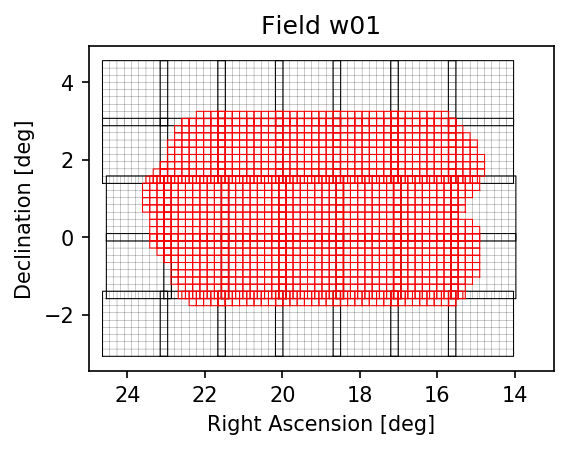

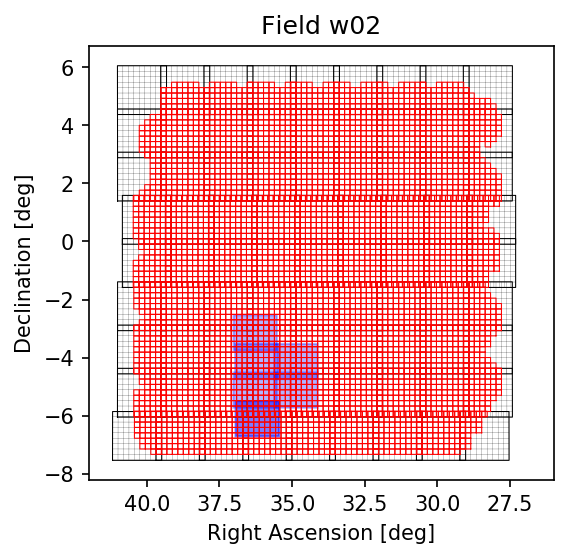

In [24]:
!mkdir figs
for i in np.arange(1,3):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
    field = 'w0{}'.format(i)

    #Get official list of tracts that define field
    f = open(patch_files[field], 'r')
    tracts = set()
    for x in f:
        if x.startswith('Tract'):
            tracts.add(int(x.split(' ')[1]))  
    full_patch_dict = {}
    band_dict = { hsc_bands[i]: {} for i in range(len(hsc_bands))}
    for tract in tracts:
        full_patch_dict[tract] = [
            s for s in np.unique(np.array(hsc_ims[ (hsc_ims['tract'] == str(tract))]['patch']))
        ]
        for band in hsc_bands:
            band_dict[band][tract] = [
                s for s in np.unique(np.array(hsc_ims[
                    (hsc_ims['tract'] == str(tract))
                    & (hsc_ims['band'] == band)
                ]['patch']))
            ]

    #Plot all the tracts and patchs as a grey background        
    for tract in tracts:
        vertices = sm.generateTract(tract).getVertexList()
        ra = [vertices[n][0].asDegrees() for n in np.mod(np.arange(5),4)]
        dec = [vertices[n][1].asDegrees() for n in np.mod(np.arange(5),4)]
        ax.plot(ra, dec, c = 'k', linewidth=0.5)
        for p in np.nditer(np.meshgrid(np.arange(0,9), np.arange(0,9))):
            #print(p[0], p[1])
            t = sm.generateTract(tract)
            vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
            ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
            #print(tract, ra)
            dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
            ax.plot(ra, dec, c = 'k', alpha=0.5, linewidth=0.1)

    #Plot patches that have HSC files on a band
    band = 'all'
    if band != 'all':
        d = band_dict[band]
    else:
        d = full_patch_dict
    for tract in d:
        for patch in d[tract]:
            #print(p[0], p[1])
            p = [int(i) for i in patch.split(',')]
            t = sm.generateTract(tract)
            vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
            ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
            #print(tract, ra)
            dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
            ax.plot(ra, dec, c = 'r', alpha=1.0, linewidth=0.5)


    v_band ='Ks' #& (viking_ims['filter'] == v_band)
    for t in viking_ims[viking_near[field] & (viking_ims['type'] == 'tile') & (viking_ims['filter'] == v_band) ]:

        ra = [t['ra_0_0'], t['ra_x_0'] , t['ra_x_y'] , t['ra_0_y'] , t['ra_0_0'] ]
        dec = [t['dec_0_0'], t['dec_x_0'] , t['dec_x_y'] , t['dec_0_y'] , t['dec_0_0'] ]

        ax.fill(ra,dec, c = 'b', alpha=0.3)



    ax.set_title("Field {}".format(field))
    ax.axis('scaled')
    ax.set_xlim([lims[field][1]+1, lims[field][0]-1])
    ax.set_xlabel('Right Ascension [deg]')
    ax.set_ylabel('Declination [deg]')
    plt.show()
    fig.savefig('./figs/{}_HSC-{}_tracts.pdf'.format(field,band), overwrite=True)
    fig.savefig('./figs/{}_HSC-{}_tracts.png'.format(field,band), overwrite=True)

mkdir: figs: File exists


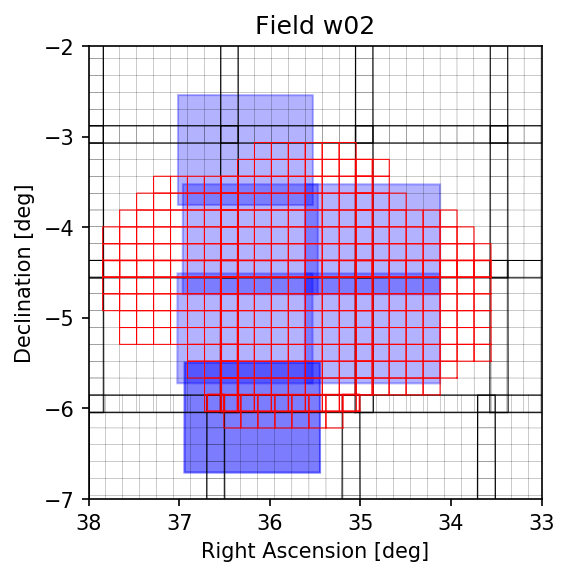

In [30]:
!mkdir figs
for i in np.arange(2,3):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
    field = 'w0{}'.format(i)

    #Get official list of tracts that define field
    f = open(patch_files[field], 'r')
    tracts = set()
    for x in f:
        if x.startswith('Tract'):
            tracts.add(int(x.split(' ')[1]))  
    full_patch_dict = {}
    band_dict = { hsc_bands[i]: {} for i in range(len(hsc_bands))}
    for tract in tracts:
        full_patch_dict[tract] = [
            s for s in np.unique(
                np.array(
                    hsc_ims[ 
                        (hsc_ims['tract'] == str(tract))
                        & (hsc_ims['depth'] == 'pdr2_dud')                        
                    ]['patch'])
            )
        ]
        for band in hsc_bands:
            band_dict[band][tract] = [
                s for s in np.unique(np.array(hsc_ims[
                    (hsc_ims['tract'] == str(tract))
                    & (hsc_ims['band'] == band)
                ]['patch']))
            ]

    #Plot all the tracts and patchs as a grey background        
    for tract in tracts:
        vertices = sm.generateTract(tract).getVertexList()
        ra = [vertices[n][0].asDegrees() for n in np.mod(np.arange(5),4)]
        dec = [vertices[n][1].asDegrees() for n in np.mod(np.arange(5),4)]
        ax.plot(ra, dec, c = 'k', linewidth=0.5)
        for p in np.nditer(np.meshgrid(np.arange(0,9), np.arange(0,9))):
            #print(p[0], p[1])
            t = sm.generateTract(tract)
            vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
            ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
            #print(tract, ra)
            dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
            ax.plot(ra, dec, c = 'k', alpha=0.5, linewidth=0.1)

    #Plot patches that have HSC files on a band
    band = 'all'
    if band != 'all':
        d = band_dict[band]
    else:
        d = full_patch_dict
    for tract in d:
        for patch in d[tract]:
            #print(p[0], p[1])
            p = [int(i) for i in patch.split(',')]
            t = sm.generateTract(tract)
            vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
            ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
            #print(tract, ra)
            dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
            ax.plot(ra, dec, c = 'r', alpha=1.0, linewidth=0.5)


    v_band ='Ks' #& (viking_ims['filter'] == v_band)
    for t in viking_ims[viking_near[field] & (viking_ims['type'] == 'tile') & (viking_ims['filter'] == v_band) ]:

        ra = [t['ra_0_0'], t['ra_x_0'] , t['ra_x_y'] , t['ra_0_y'] , t['ra_0_0'] ]
        dec = [t['dec_0_0'], t['dec_x_0'] , t['dec_x_y'] , t['dec_0_y'] , t['dec_0_0'] ]

        ax.fill(ra,dec, c = 'b', alpha=0.3)



    ax.set_title("Field SXDS (DUD region within w02)")
    ax.axis('scaled')
    ax.set_xlim([38, 33])
    ax.set_ylim([-7, -2])
    ax.set_xlabel('Right Ascension [deg]')
    ax.set_ylabel('Declination [deg]')
    plt.show()
    fig.savefig('./figs/{}_HSC-{}_DUD_tracts.pdf'.format(field,band), overwrite=True)
    fig.savefig('./figs/{}_HSC-{}_DUD_tracts.png'.format(field,band), overwrite=True)

Field: w03


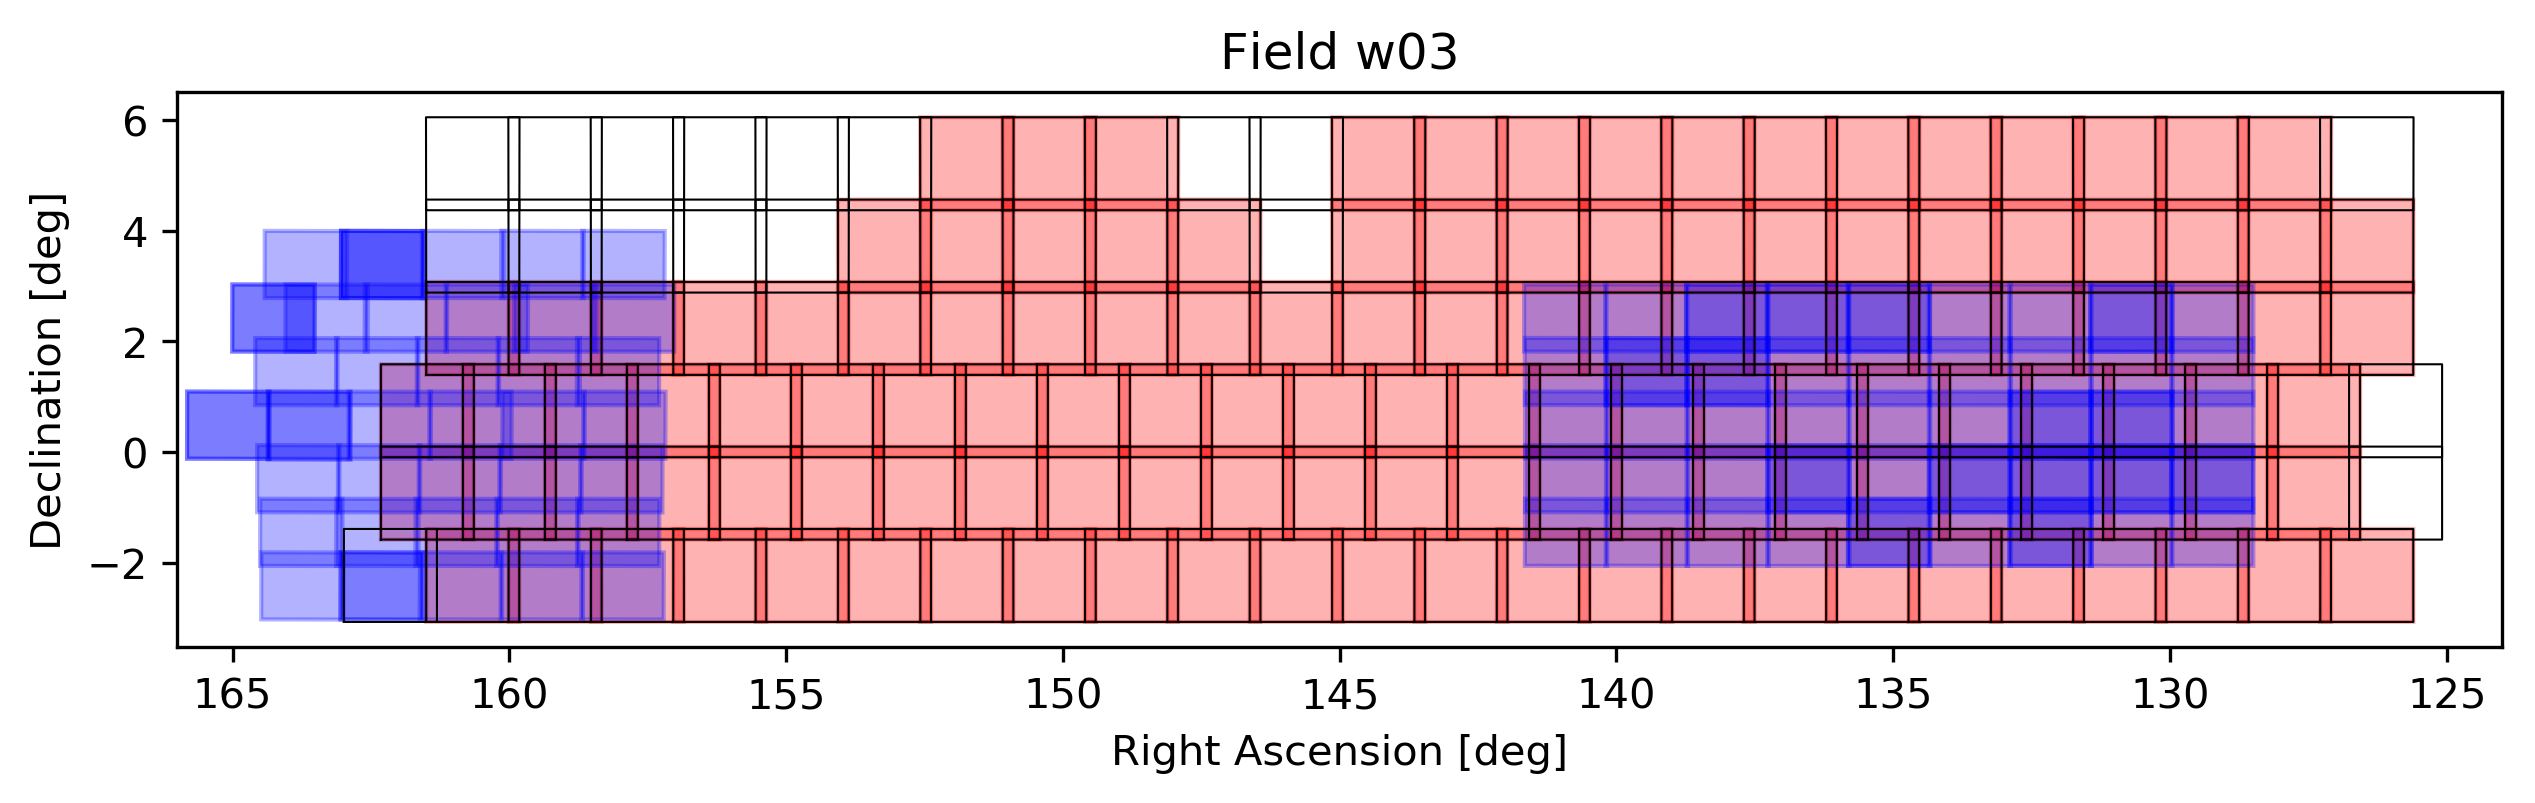

Field: w04


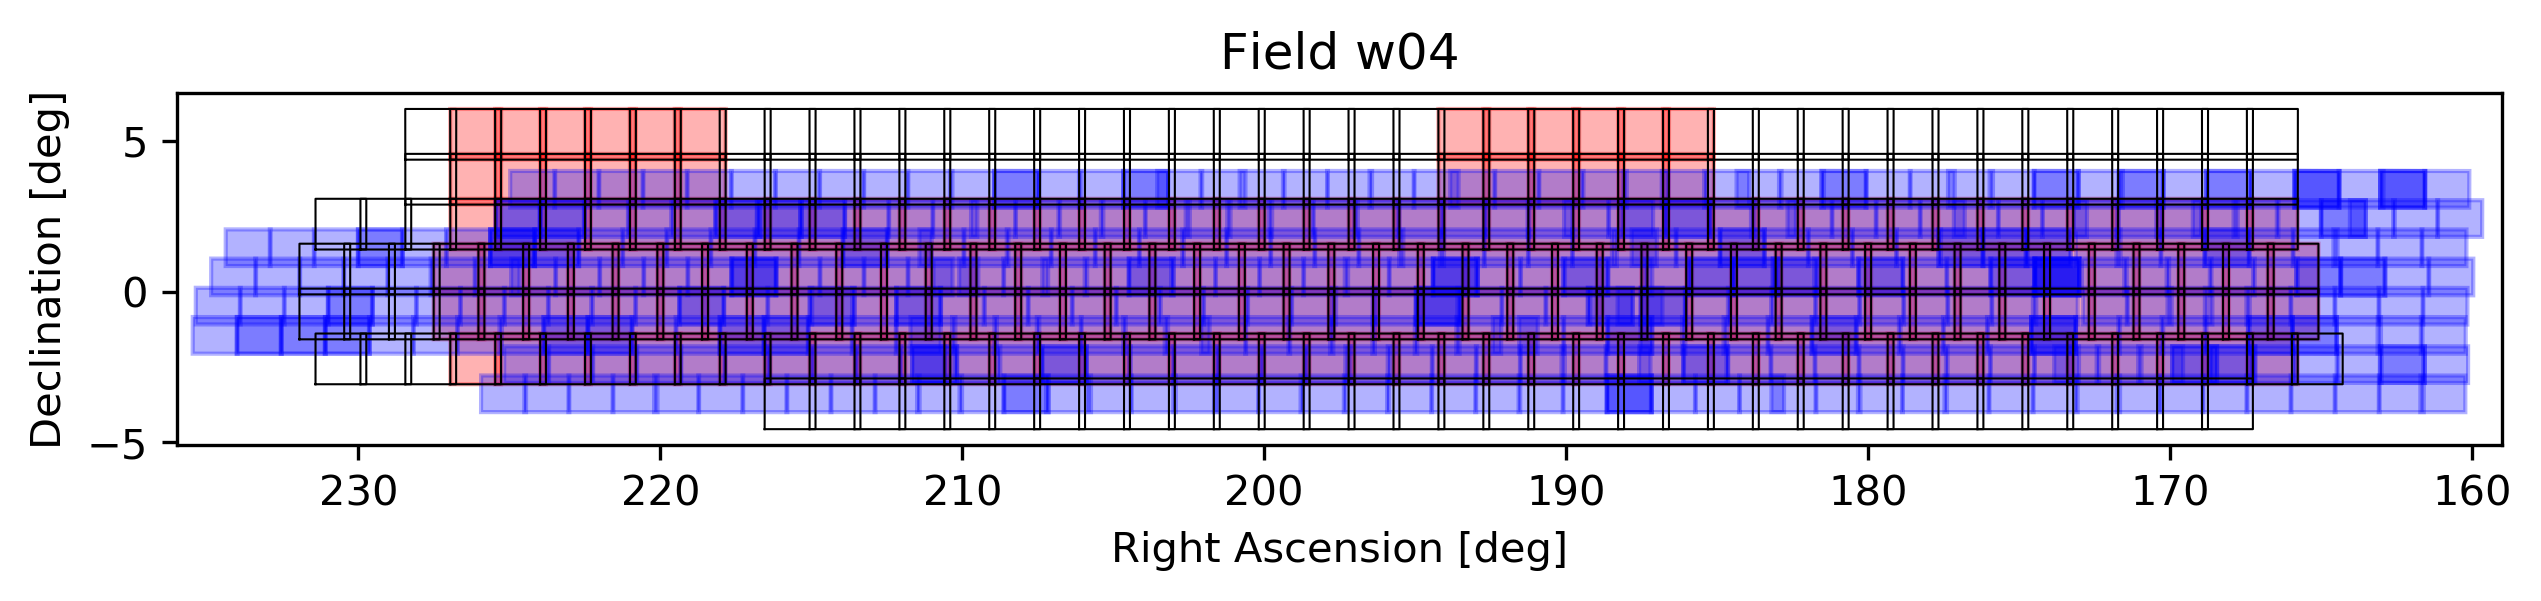

Field: w05


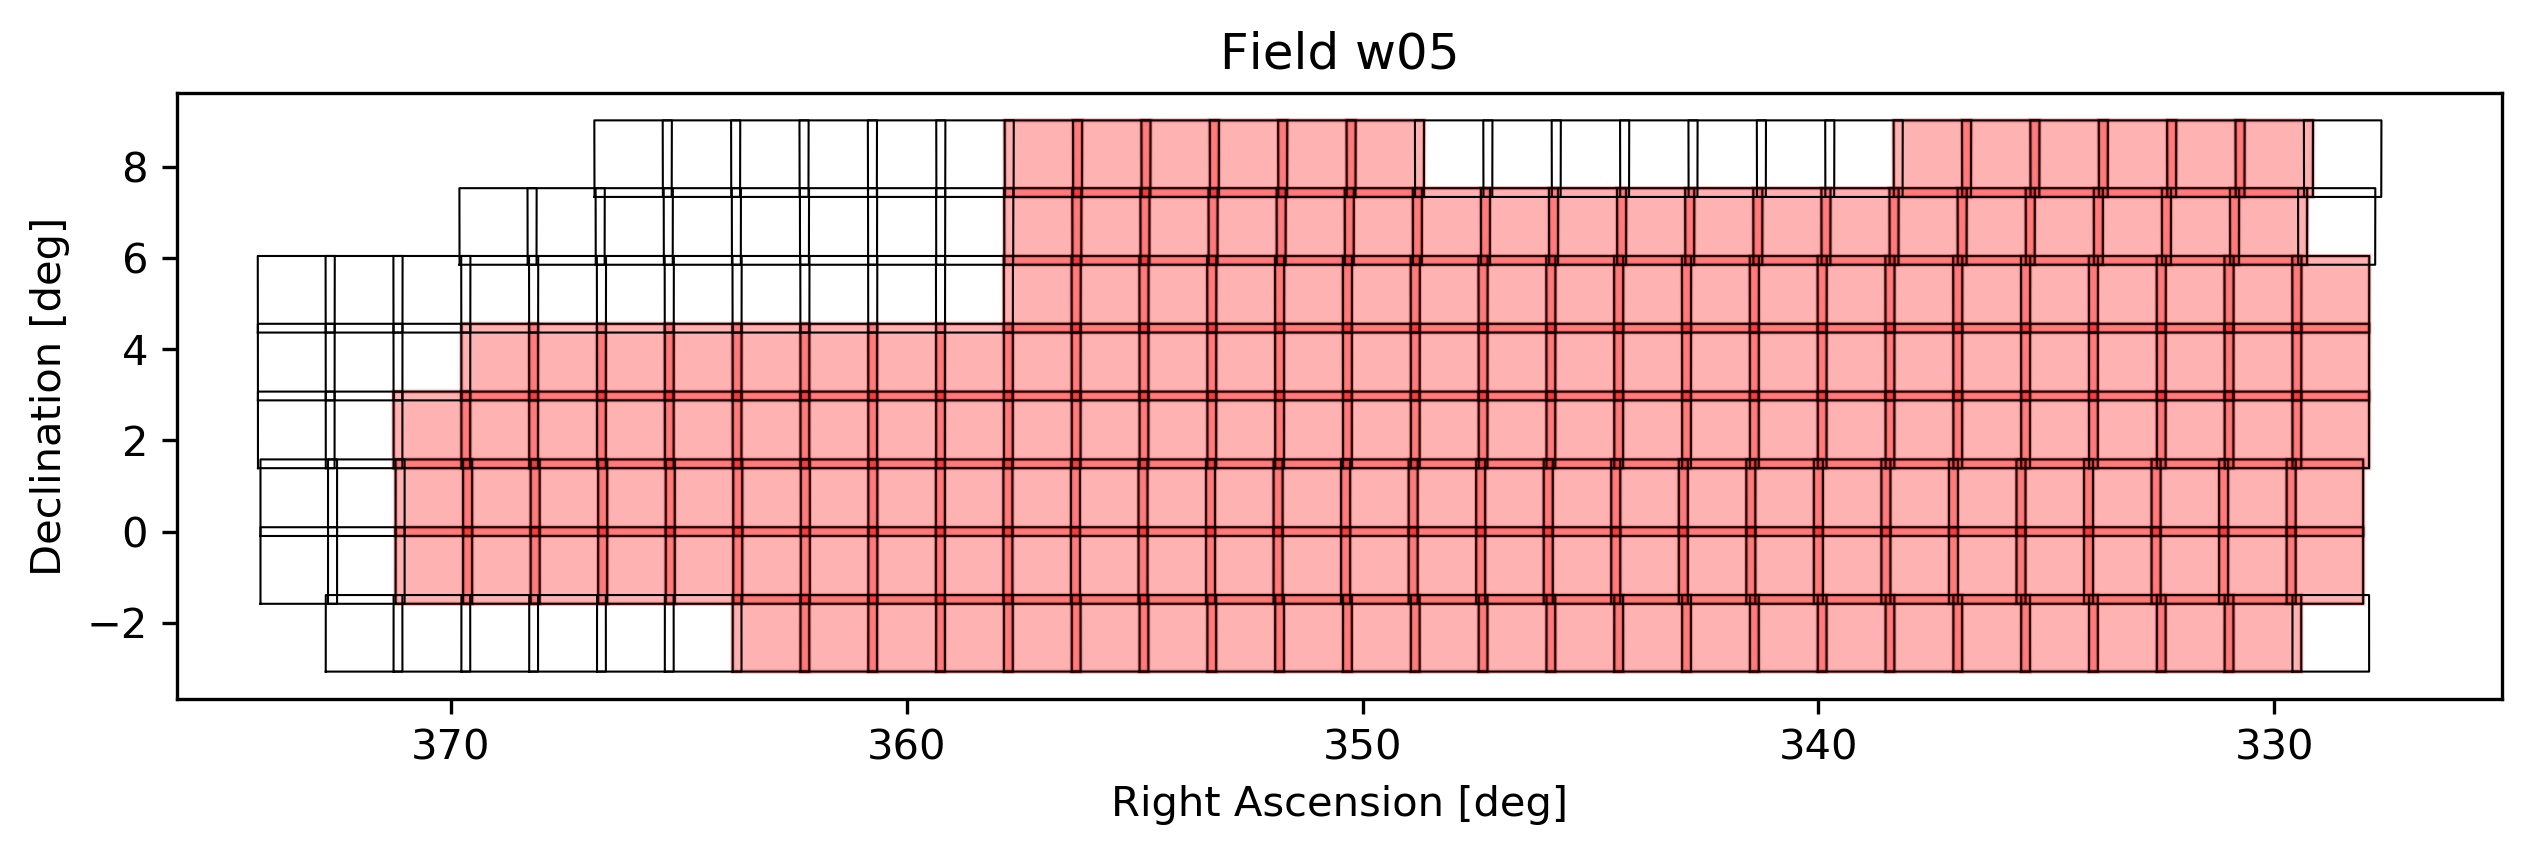

In [17]:
for i in np.arange(3,6):
    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
    field = 'w0{}'.format(i)
    print('Field: {}'.format(field))
    #Get official list of tracts that define field
    f = open(patch_files[field], 'r')
    tracts = set()
    for x in f:
        if x.startswith('Tract'):
            tracts.add(int(x.split(' ')[1]))  
    full_patch_dict = {}
    band_dict = { hsc_bands[i]: {} for i in range(len(hsc_bands))}
    for tract in tracts:
        full_patch_dict[tract] = [
            s for s in np.unique(np.array(hsc_ims[ (hsc_ims['tract'] == str(tract))]['patch']))
        ]
        for band in hsc_bands:
            band_dict[band][tract] = [
                s for s in np.unique(np.array(hsc_ims[
                    (hsc_ims['tract'] == str(tract))
                    & (hsc_ims['band'] == band)
                ]['patch']))
            ]

    #Plot all the tracts and patchs as a grey background        
    for tract in tracts:
        vertices = sm.generateTract(tract).getVertexList()
        ra = [vertices[n][0].asDegrees() for n in np.mod(np.arange(5),4)]
        for i in np.arange(5):
            if ra[i]<100:
                ra[i] = ra[i]+360
        dec = [vertices[n][1].asDegrees() for n in np.mod(np.arange(5),4)]
        ax.plot(ra, dec, c = 'k', linewidth=0.5)
#         for p in np.nditer(np.meshgrid(np.arange(0,9), np.arange(0,9))):
#             #print(p[0], p[1])
#             t = sm.generateTract(tract)
#             vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
#             ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
#             #print(tract, ra)
#             dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
#             ax.plot(ra, dec, c = 'k', alpha=0.5, linewidth=0.1)

    #Plot tracts?patches that have HSC files on a band
    band = 'all'
    if band != 'all':
        d = band_dict[band]
    else:
        d = full_patch_dict
    for tract in d:
        if  len(d[tract])==0:
            continue
        vertices = sm.generateTract(tract).getVertexList()
        ra = [vertices[n][0].asDegrees() for n in np.mod(np.arange(5),4)]
        for i in np.arange(5):
            if ra[i]<100:
                ra[i] = ra[i]+360
        dec = [vertices[n][1].asDegrees() for n in np.mod(np.arange(5),4)]
        ax.fill(ra, dec, c = 'r', alpha=0.3)
#         for patch in d[tract]:
#             #print(p[0], p[1])
#             p = [int(i) for i in patch.split(',')]
#             t = sm.generateTract(tract)
#             vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
#             ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
#             #print(tract, ra)
#             dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
#             #ax.plot(ra, dec, c = 'r', linewidth=0.6)
#             ax.fill(ra, dec, c = 'r', alpha=0.3)


    v_band ='Ks'
    for t in viking_ims[viking_near[field] & (viking_ims['type'] == 'tile') & (viking_ims['filter'] == v_band) ]:

        ra = [t['ra_0_0'], t['ra_x_0'] , t['ra_x_y'] , t['ra_0_y'] , t['ra_0_0'] ]
        dec = [t['dec_0_0'], t['dec_x_0'] , t['dec_x_y'] , t['dec_0_y'] , t['dec_0_0'] ]
        for i in np.arange(5):
            if ra[i]<100:
                ra[i] = ra[i]+360
        ax.fill(ra,dec, c = 'b', alpha=0.3)



    ax.set_title("Field {}".format(field))
    ax.axis('scaled')
    ax.set_xlim([lims[field][1]+1, lims[field][0]-1])
    ax.set_xlabel('Right Ascension [deg]')
    ax.set_ylabel('Declination [deg]')
    plt.show()
    fig.savefig('./figs/{}_HSC-{}_tracts.pdf'.format(field,band), overwrite=True)
    fig.savefig('./figs/{}_HSC-{}_tracts.png'.format(field,band), overwrite=True)

In [18]:
#How many diferent exposure times for stacks are there
np.unique(viking_ims[(viking_ims['type'] == 'stack')  ]['exptime'])

0
1
10
25
60


## 1. Make the image job dictionaries

We will now create a dictionary mapping integer 0 indexed job ids to job options to reduce the number of slurm files required. This dictionary can then be saved as a json file and passed to the bash script which runs the process. We may wish to move to pure Python to make this more tidy. 

In [19]:
print(
    np.min([int(d) for d in viking_ims[(viking_ims['type'] == 'stack')]['date']]), 
    np.max([int(d) for d in viking_ims[(viking_ims['type'] == 'stack')]['date']])
)

20091112 20180214


In [20]:
def raDecToTractSafe(ra,dec):
    """Return all the tracts within 2 degrees of a ra dec to get every tract covering a tile
    
    I think the function findTractPatchList excludes all tracts that do not conatin the points
    Crucially this excluded the central tracts. Perhaps we need to get the corners from the tile.
    
    """
    size = 2 #degrees safely outside tile from centre
    patches= sm.findTractPatchList([
        SpherePoint((ra)*degrees,(dec)*degrees)
        for ra, dec in np.nditer(
            np.meshgrid(
                np.linspace(ra+size,ra-size,num=int(size/0.5)),
                np.linspace(dec+size,dec-size,num=int(size/0.5)),
            )
        )
    ])
    tracts = set([p[0].getId() for p in patches])
    t =''
    for n in tracts:
        t += '^{}'.format(n)
    return t[1:]
    
print(
    viking_ims[(viking_ims['type'] == 'stack')][0]['ra'], 
    viking_ims[(viking_ims['type'] == 'stack')][0]['dec'],
    raDecToTractSafe(
        viking_ims[(viking_ims['type'] == 'stack')][0]['ra'],
        viking_ims[(viking_ims['type'] == 'stack')][0]['dec']
    )
)

4.395633 -28.63972 4608^5249^5250^5251^5252^4610^4609^5032^5033^5034^5035^4818^4819^4820^4821^4607


In [25]:
for i in np.arange(1,6):
    field = 'w0{}'.format(i)
    images_job_dict = {}
 
    ims_to_run=viking_ims[viking_near[field] & (viking_ims['type']=='stack')]
    n = len(ims_to_run)
    #Run over every stack image in the field
    for i in np.arange(n):
        date=ims_to_run[i]['date']
        images_job_dict[str(i)] = [
            '{}-{}-{}'.format(date[0:4],date[4:6],date[6:9]),
            ims_to_run[i]['numObs'],
            'VISTA-{}'.format(ims_to_run[i]['filter']),
            raDecToTractSafe(ims_to_run[i]['ra'],ims_to_run[i]['dec']),
            ims_to_run[i]['file']
        ]
    dict_name ='./slurm/{}_images_job_dict_{}.json'.format(field,n)
    if n==0:
        print('Field {}: {} patches, no dict written'.format(field,n))
        continue
    print('Field {}: {} images, dict written to {}'.format(field,n,dict_name))
    with open(dict_name, 'w') as outfile:
        json.dump(images_job_dict, outfile, separators=(',', ':'))

Field w01: 0 patches, no dict written
Field w02: 306 images, dict written to ./slurm/w02_images_job_dict_306.json
Field w03: 3595 images, dict written to ./slurm/w03_images_job_dict_3595.json
Field w04: 17171 images, dict written to ./slurm/w04_images_job_dict_17171.json
Field w05: 0 patches, no dict written


# 2. Make the patch job array dictionaries

For each field we want the patches that are in HSC and have VIKING coverage.

In [26]:
for i in np.arange(1,6):
    field = 'w0{}'.format(i)
    #get tracts in field
    tracts = set()
    for x in open(patch_files[field], 'r'):
        if x.startswith('Tract'):
            tracts.add(int(x.split(' ')[1]))  
    

    hsc_patch_dict = {}
    viking_patch_dict = {}
    patch_job_dict = {}
    n=0
    for tract in tracts:
        hsc_patch_dict[tract] = [
            s for s in np.unique(np.array(hsc_ims[ (hsc_ims['tract'] == str(tract))]['patch']))
        ]
        try:
            viking_patch_dict[tract] = ["{},{}".format(p[0],p[1]) for p in viking_total_patch_dict[str(tract)]]
        except KeyError:
            viking_patch_dict[tract] = []
        for patch in np.nditer(np.meshgrid(np.arange(9),np.arange(9))):
            patch="{},{}".format(patch[0],patch[1])
            #check if patch is in both regions
            in_hsc = patch in hsc_patch_dict[tract]
            in_viking = patch in viking_patch_dict[tract]
            if in_hsc and in_viking:
                patch_job_dict[str(n)]=[tract, patch ]
                n+=1
    
   
    
    
    dict_name ='./slurm/{}_patch_job_dict_{}.json'.format(field,n)
    if n==0:
        print('Field {}: {} patches, no dict written'.format(field,n))
        continue
    print('Field {}: {} patches, dict written to {}'.format(field,n,dict_name))
    with open(dict_name, 'w') as outfile:
        json.dump(patch_job_dict, outfile, separators=(',', ':'))

Field w01: 0 patches, no dict written
Field w02: 386 patches, dict written to ./slurm/w02_patch_job_dict_386.json
Field w03: 3342 patches, dict written to ./slurm/w03_patch_job_dict_3342.json
Field w04: 11829 patches, dict written to ./slurm/w04_patch_job_dict_11829.json
Field w05: 0 patches, no dict written
